In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pywt

In [2]:
def compare_images(original_image, noisy_image, denoised_image, Title = ""):

    fig, axes = plt.subplots(1, 3, figsize=(10, 6))
    axes[0].set_title("Original Image")
    axes[1].set_title(Title)
    axes[2].set_title("Restored Image")


    axes[0].imshow(original_image, cmap='gray')
    axes[1].imshow(noisy_image, cmap='gray')
    axes[2].imshow(denoised_image, cmap='gray', vmin = 0, vmax = 1)

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()

    plt.show()


In [4]:
image = Image.open('ManTestImage.bmp').convert('L')

In [5]:
def addNoise(arr, prob = 0.4):
    mask = np.random.choice([0.0, 1.0], size = arr.shape, p = [prob, 1.0 - prob])
    return arr * mask, mask

In [6]:
def prox(X, Lambda = 1.0):
    Y = []
    for x in X:
        y = np.maximum(0, np.abs(x) - Lambda) * np.sign(x)
        Y.append(y)
    return Y

In [7]:
def Fista(noisy_image, mask, Gamma, Lambda, Level, Alpha = 1.0):

    x = noisy_image
    y = noisy_image
    u = noisy_image
    M = mask.reshape(-1)
    t = 1.0

    x_prev = x
    t_prev = t

    for n in range(180):

        grad_f = M * (y - noisy_image)                      # f(x) 0.5||y_0 - Mx||^2 , M is mask
        z = y - Gamma * grad_f                              # z is a variable to hold 'y - gamma * grad_f(y)'

        coeff = pywt.wavedec(z, 'db10', level=Level)       # Coeff is a list of the low and high passes of the signal
        coeff_soft = prox(coeff, Gamma * Lambda)            # Get the soft thresholded values of the coeffs, using pywt.wavedec

        coeff_diff = [coeff_soft[i] - coeff[i] for i in range(len(coeff))]


        x =  z + pywt.waverec(coeff_diff, 'db10')                # Get the inverse transform using pywt.waverec

        t = np.sqrt(t**2 + 0.25) + 0.5                      # Update value of t

        y = (1.0 - 1.0 / t) * x + (1.0 / t) * u             # Update value of y

        u = x_prev + t_prev * (x - x_prev)                       # Update value of u

        x_prev = x
        t_prev = t
    
    return x


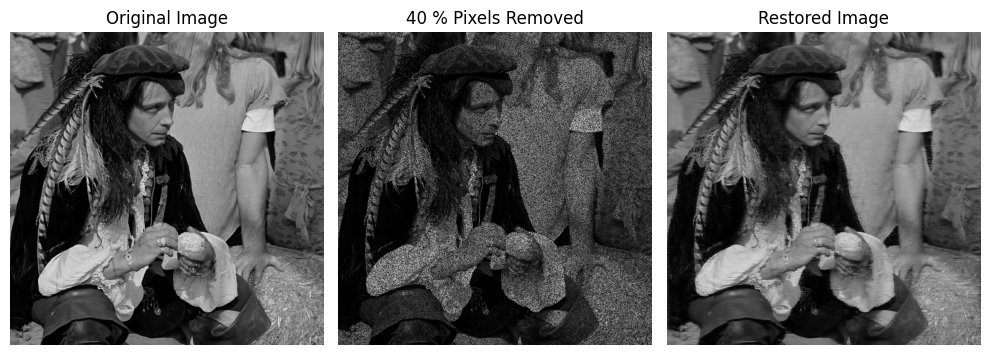

In [8]:
x = np.array(image, dtype =float) / 255.0
noisy_image, mask = addNoise(x, prob=0.4)

denoised = Fista(noisy_image.reshape(-1), mask, 1.13, 0.025, Level = 10).reshape(x.shape)

compare_images(x, noisy_image, denoised, "40 % Pixels Removed")

Search for Best Hyperparameters

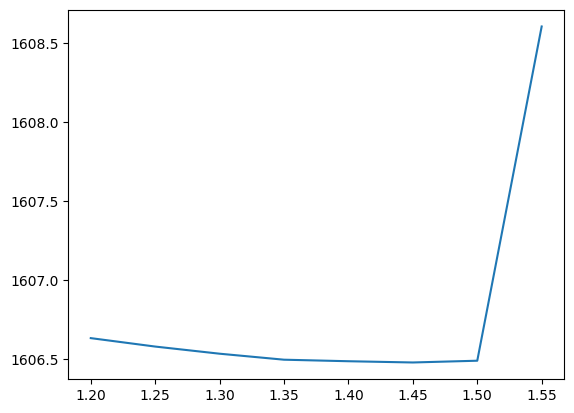

In [23]:
Gamma = 1.2

gamma_list = []
mse_list = []

while(Gamma <= 1.6):
    denoised = Fista(noisy_image.reshape(-1), mask, Gamma, 0.025, 10).reshape(x.shape)
    mse = np.sum(np.square(denoised - x))

    gamma_list.append(Gamma)
    mse_list.append(mse)

    Gamma += 0.05

plt.plot(gamma_list, mse_list)
plt.show()

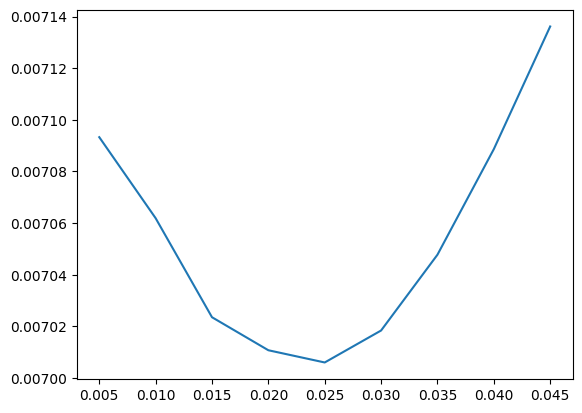

In [18]:
Lambda = 0.005

Lambda_list = []
mse_list = []

while(Lambda <= 0.045):
    denoised = Fista(noisy_image.reshape(-1), mask, 1.13, Lambda, 10).reshape(x.shape)
    mse = np.sum(np.square(denoised - x)) / noisy_image.size
    Lambda_list.append(Lambda)
    mse_list.append(mse)

    Lambda += 0.005

plt.plot(Lambda_list, mse_list)
plt.show()

In [9]:
print(np.mean(np.square(x - denoised)))

0.003120451890919635


In [12]:
print(np.min(mse_list))

3.4119417670134804
